In [1]:
#%%shell
#julia
#using Pkg # Make sure everything is installed
#Pkg.add(["DataFrames", "Plots", "StatsBase", "Distributions", "Statistics", "LsqFit", "Distributed",
# "NaNStatistics", "Revise", "ColorSchemes"])
using DataFrames, Plots, StatsBase, Distributions, Statistics, LsqFit, Distributed,
      NaNStatistics, Base.Threads, Revise, ColorSchemes
include.(("ConstantSimulations.jl", "StaircaseSimulations.jl"))

# Psychophysics helper functions
jnd2sigma(j::Real) = (1 /quantile(Normal(), 0.75)) * j # Convert JND to σ
sigma2k(sigma::Real) = 1.7 / sigma; # Convert σ to k
sigmoid(x::Vector, coeffs::Vector) = 1 ./ (1 .+ exp.(-coeffs[1].*(x.-coeffs[2])))

# Plotting defaults
font = Plots.font("Helvetica", 9, "rgb(200,200,200)")
gr() # GR backend
gr(guidefont=font, xtickfont=font, ytickfont=font, annotationfontfamily=font, annotationfontsize=9,
 legend=false, background_color = "rgb(30,30,30)");

##### Defining the Psychometric Function
We first define an example psychophysical response function defined as a cumulative normal distribution where we define the detection threshold (μ) and just noticeable difference (which we then convert to σ). You can edit the 'detection_threshold' and 'jnd' values and re-run the cell to see how the shape of the psychometric curve changes. Note that the JND is defined as half of the distance between p(.75) and p(.25) stimulus levels. Thus, on the graph below the JND lines indicate the p(.25) and p(.75) values, but the JND is half range between them.

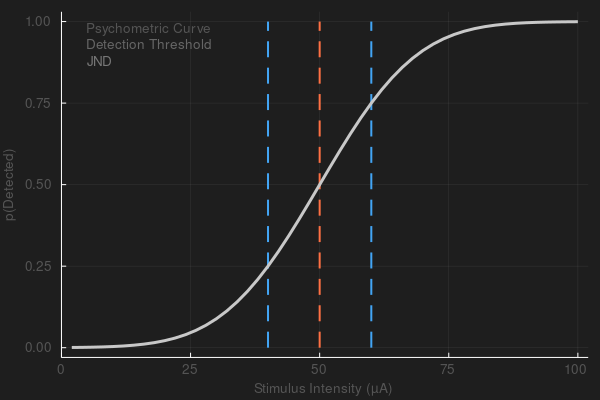

In [2]:
valid_stims = collect(2:2:100) # These are the amplitudes that can be given 
detection_threshold = 50 # microamps
jnd = 10 # microamps
sigma = jnd2sigma(jnd) # Convert for producing normal distribution
psychometric_pdf = Normal(detection_threshold, sigma) # The normal distribution
pDetected = cdf(psychometric_pdf, valid_stims) # Response probability at each stimulus

labels = ["Psychometric Curve", "Detection Threshold", "JND"]
label_colors = ["rgb(200,200,200)", "rgb(255, 112, 67)", "rgb(66, 165, 245)"]

GroundTruthPlot = plot(xlabel = "Stimulus Intensity (μA)",ylabel = "p(Detected)", xlim=(0, 102))
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold], [0, 1],
     linecolor = "rgb(255, 112, 67)", linestyle = :dash, linewidth = 2)
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].- jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # detection_threshold
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].+ jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # JND
    plot!(GroundTruthPlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)

    yl = 1; y_dec = .05
    for (l,c) in zip(labels, label_colors)
        annotate!(GroundTruthPlot, 5, yl, l, annotationhalign=:left, annotationvalign=:top, annotationcolor=c)
        yl -= y_dec
    end
    display(GroundTruthPlot)

##### Unconstrained Method of Constants:
With no prior knowledge of the psychometric curve we have to span the full range of stimuli and sample the response probability at each stimulus level. Importantly, we will always simulate this as an 2-Alternate Forced Choice (2AFC) experiment as this is the most commonly used format as it minimizes response bias without extending the duration of the experiment excessively. This means that there is a chance (1/#AFC) that the testee will select the correct interval randomly. Thus, the p(Detected) needs to be adjusted to account for this. This reduces probability bias but, as can be seen below, massively increases the variability in the measured p(Detected).

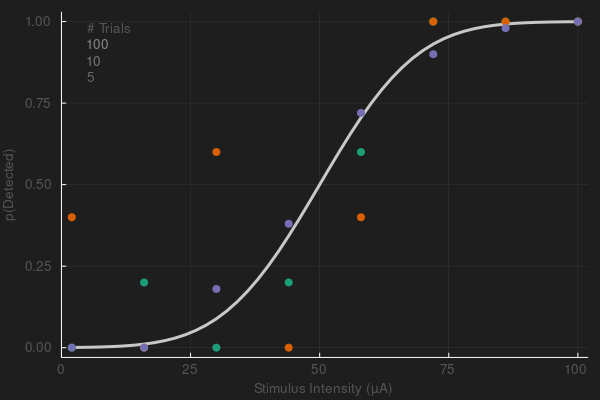

In [3]:
# Here we will choose which stimulus levels to test at
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Unconstrained")
# Prepare plot
ConstantExamplePlot = plot(xlabel = "Stimulus Intensity (μA)", ylabel = "p(Detected)", xlim=(0, 102))
    plot!(ConstantExamplePlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)
    # Show for each number of trial
    yl = .85; y_dec = .05
    for (i,num_trials) in enumerate([5, 10, 100])
        _, pd = ConstantSimulation(test_stims, test_stims_pDetected, num_trials, NumPerms = 1, NumAFC = 2)
        scatter!(ConstantExamplePlot, test_stims, vec(pd),  marker=:circle, markersize=5, markeralpha=1,
        markercolor=ColorSchemes.Dark2_3[i], markerstrokecolor=ColorSchemes.Dark2_3[i])
        annotate!(ConstantExamplePlot, 5, yl, num_trials, annotationhalign=:left, annotationvalign=:top,
        annotationcolor=markerstrokecolor=ColorSchemes.Dark2_3[i])
        yl = yl + y_dec
    end
    annotate!(ConstantExamplePlot, 5, yl, "# Trials",
    annotationhalign=:left, annotationvalign=:top, annotationcolor="rgb(200,200,200)")
    display(ConstantExamplePlot)

Given that we used a 2AFC-task above, even with 100 trials we don't perfectly capture the distribution every time. You can re-run the cell to see how much variation there is, something that isn't present when NumAFC = 1, though that suffers from response bias.

##### Adaptive Methods: Transformed Staircase
The alternative approach is to 'adapt' to the responses and adjust the stimuli according to session history. One of the most popular approaches is the transformed staircase. In this approach you set a criteria and adjust the stimulus level once the criterion has been reached. The standard method is a 3U/1D staircase where the stimulus level decreases when the response is correct 3 times in a row and increases when the response is incorrect 1 time in a row. Each time the direction that the staircase is moving changes we count this after a reversion. The staircase will stop after a set number of reversions.

Importantly, each criterion will converge at a different location as will the task design. For example, 1-interval task with 1U/1D criterion will converge at 50%. However, a 2AFC task will 'converge' at 50% when no stimulus is present. Similarly, a 3U/1D criterion in 1-interval will target 75%, but in 2AFC will target ~56%.

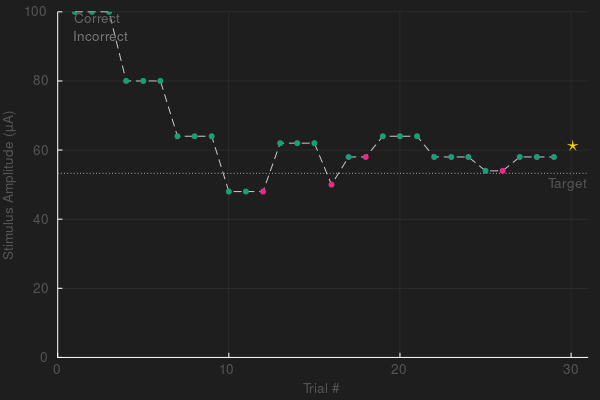

In [4]:
criterion = [3,1]
num_afc = 2;
target_p = GetTransformedStaircaseTarget(num_afc, criterion)
target_amplitude = quantile(Normal(detection_threshold, sigma), target_p)
# Single staircase simulation
amplitude_history, detection_history, reversion_history, estimated_thresholds, stop_point = 
 TransformedStaircaseSimulation(valid_stims,  pDetected, Criterion = criterion,
  MaxReversions = 7, NumPerms = 1, NumAFC = num_afc) 
# Identify which trials were correct/incorrect
term_idx = findfirst(isnan.(amplitude_history))[1]
correct_idx = findall(vec(detection_history[1:term_idx]) .== 1)
incorrect_idx = findall(vec(detection_history[1:term_idx]) .== 0)

# Make the plot
StaircaseExamplePlot = plot(xlabel = "Trial #", ylabel = "Stimulus Amplitude (μA)",
  xlim=(0, term_idx+1), ylim=(0,100))
  # Show target/convergence point
  plot!(StaircaseExamplePlot, [0,term_idx+1], [target_amplitude, target_amplitude], color="rgb(200,200,200)", linestyle=:dot)
  annotate!(StaircaseExamplePlot, term_idx+1, target_amplitude-1, "Target",
  annotationhalign=:right, annotationvalign=:top, annotationcolor="rgb(200,200,200)")
  # Show trial history
  plot!(StaircaseExamplePlot, 1:term_idx, amplitude_history[1:term_idx], color="rgb(200,200,200)", linestyle=:dash)
  scatter!(StaircaseExamplePlot, correct_idx, amplitude_history[correct_idx], markercolor=ColorSchemes.Dark2_3[1],
  markerstrokecolor=ColorSchemes.Dark2_3[1])
  scatter!(StaircaseExamplePlot, incorrect_idx, amplitude_history[incorrect_idx], markercolor=ColorSchemes.Dark2_4[4],
  markerstrokecolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, 1, 100, "Correct",
  annotationhalign=:left, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_3[1])
  annotate!(StaircaseExamplePlot, 1, 95, "Incorrect",
  annotationhalign=:left, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, term_idx+0.5, estimated_thresholds[1], "⋆",
  annotationhalign=:right, annotationvalign=:center, annotationcolor=:gold, annotationfontsize=15)
  display(StaircaseExamplePlot)

##### Comparing Time & Accuracy
The above code blocks show that either method can be used to measure/estimate the detection threshold though. To answer the question of which is better though, their performance needs to be compared. The most obvious metric, for a time consciouss experimenter, is how the accuracy of the estimate changes with time. Thus, we can allow for more repeats at each stimulus intensity for the method of constant stimulation and allow for more reversions in the transformed staircase. 
Warning: This is the first simulation that will take a long time.

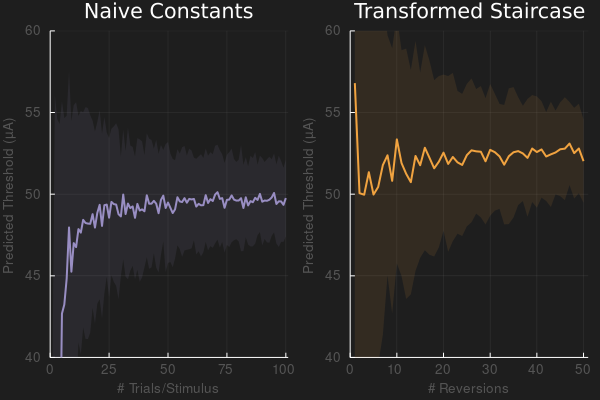

In [14]:
max_repeats_per_intensity = 100 # A beyond reasonable number of trials
max_num_reversions = 50 # Similarly excessive
num_perms = 100 # Increase this for smoother/cleaner results at the expense of time

# Simulate the method of constants
constant_num_trials_t_est = zeros(max_repeats_per_intensity, num_perms); fill!(constant_num_trials_t_est, NaN)
for MaxReps = 1:max_repeats_per_intensity
    constant_num_trials_t_est[MaxReps,:], _ = ConstantSimulation(test_stims, test_stims_pDetected,
    MaxReps, NumPerms = num_perms, NumAFC = 2, BoundSig=false)
end
# Compute stats across permutations
t_mean_uconsts = vec(nanmean(constant_num_trials_t_est, dims = 2))
t_std_uconsts = vec(nanstd(constant_num_trials_t_est, dims = 2))
t_error_uconsts = vec(nanmean((constant_num_trials_t_est .- detection_threshold).^2, dims = 2))

# Repeat for the staircase and number of reversions
staircase_num_revs_t_est = zeros(max_num_reversions, num_perms); fill!(staircase_num_revs_t_est, NaN)
for MaxReversions = 1:max_num_reversions
  _, _, _, staircase_num_revs_t_est[MaxReversions,:], _ = TransformedStaircaseSimulation(valid_stims,
   pDetected, MaxReversions = MaxReversions, NumPerms = num_perms, NumAFC = 2)
end
# Compute stats across permutations
t_mean_tstairs = vec(nanmean(staircase_num_revs_t_est, dims = 2))
t_std_tstairs = vec(nanstd(staircase_num_revs_t_est, dims = 2))
t_error_tstairs = vec(nanmean((staircase_num_revs_t_est .- target_amplitude).^2, dims = 2))

# Make plots comparing the two
x = collect(1:max_repeats_per_intensity)
ConstantsNumTrialsPlot = plot(xlabel = "# Trials/Stimulus", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_repeats_per_intensity+1), ylim=(40,60), title="Naive Constants")
plot!(ConstantsNumTrialsPlot, x, t_mean_uconsts, ribbon=t_std_uconsts, fillalpha=0.1, linewidth=2,
  linecolor=ColorSchemes.PuOr_3[3], fillcolor=ColorSchemes.PuOr_3[3])
x = collect(1:max_num_reversions)
StairsNumRevsPlot = plot(xlabel = "# Reversions", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_num_reversions+1), ylim=(40,60), title="Transformed Staircase")
plot!(StairsNumRevsPlot, x, t_mean_tstairs, ribbon=t_std_tstairs, fillalpha=0.1, linewidth=2,
linecolor=ColorSchemes.PuOr_3[1], fillcolor=ColorSchemes.PuOr_3[1])

plot(ConstantsNumTrialsPlot, StairsNumRevsPlot)

##### Opimizing the Method of Constants
One reason that the method